# Machine Learning Model with Voting Classifier

#### We present here a simple Machine Learning model to predict the direction of the BTC price in the next day.
#### This model, although very simple, suggests the possibility of making better predictions than a 50% baseline (the response variable being binary).

In [1]:
# Array manipulations
import numpy as np

# Dataframe and its manipulations
import pandas as pd

# Indicators from talib
import talib

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Function for splitting data and evaluating models
from sklearn.model_selection import train_test_split

# Normalization
from sklearn.preprocessing import MinMaxScaler

# Models library
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Confusion matrix and classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Ignore warning
import warnings  # to ignore warnings messages
warnings.filterwarnings('ignore')

In [2]:
# NLP data set
dataframe = pd.read_csv(
    '../nlp_btc.csv'
)  # load the data set with nlp indicators inside
dataframe.set_index('Date', drop=True, inplace=True)  # Date as index
dataframe.head()

,Close,High,Low,Volume,Open,score_max,v_neg_max,v_pos_max,t_pol_max,t_sub_max,date_count,v_neg_std,v_pos_std,t_pol_std,t_sub_std
Date,,,,,,,,,,,,,,,
2016-01-01,434.334015,436.246002,427.515015,36278900.0,430.721008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,433.437988,436.062012,431.869995,30096600.0,434.622009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03,430.010986,433.743011,424.705994,39633800.0,433.578003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-04,433.091003,434.516998,429.084015,38477500.0,430.061005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,431.959991,434.182007,429.675995,34522600.0,433.069000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Use indicators from Talib

# Choose timeperiod
timeperiod = 14

# Add RSI : information on over buying and over selling
dataframe['RSI'] = talib.RSI(dataframe.Close, timeperiod=timeperiod)

# Add EMA99
dataframe['EMA99'] = talib.EMA(dataframe.Close, timeperiod=99)

# Add Stochastic
dataframe['slowk'], dataframe['slowd'] = talib.STOCH(dataframe.High,
                                                     dataframe.Low,
                                                     dataframe.Close,
                                                     fastk_period=5,
                                                     slowk_period=3,
                                                     slowk_matype=0,
                                                     slowd_period=3,
                                                     slowd_matype=0)

### Prepare the data

In [4]:
# Use data from '2017-01-01' to '2019-12-30' because of the NLP indicators
dataframe = dataframe.iloc[366:]

# Create the target
df_transit = dataframe[:-1]
df_transit['target'] = dataframe['Close'][1:].values
dataframe = df_transit

# Select variables => NLP and technical analysis
dataframe = dataframe[[
    'target', 'Close', 'RSI', 'EMA99', 'score_max', 'v_neg_max', 'v_pos_max',
    't_pol_max', 't_sub_max', 'date_count', 'v_neg_std', 'v_pos_std',
    't_pol_std', 't_sub_std', 'slowk', 'slowd'
]]

# Convert the target to binary response
def classification_target(target, last_target):
    if target > last_target:
        return 1
    else:
        return 0

# Apply to the column
dataframe['target'] = dataframe.apply(
    lambda row: classification_target(row['target'], row['Close']), axis=1)

### Normalization

In [5]:
# Data normalization

# Create array
x_values = dataframe.values

# Scaler
scaler = MinMaxScaler(feature_range=(0, 1)).fit(
    x_values)  # data normalization between 0 and 1 and training
x_scaled = scaler.transform(x_values)  # transform our data X

# To dataframe
dataframe = pd.DataFrame(x_scaled, columns=dataframe.columns)

# Drop Close
dataframe = dataframe.drop(columns='Close')

### Split the data to train and test set

In [6]:
# Split to train and test set
X_train, X_test, y_train, y_test = train_test_split(
    dataframe.iloc[:, 1:],
    dataframe.iloc[:, :1],
    test_size=0.2, # 20% of test
    random_state=122,
    stratify=dataframe.iloc[:, :1])

### Create a Voting Classifier model

In [7]:
# KNN model
model_knn = KNeighborsClassifier(n_neighbors=15)

# Randomforest model
model_Rforest = RandomForestClassifier(max_depth=100,
                                 min_samples_leaf=20,
                                 random_state=0)

# GradientBoosting model
model_Gradb = GradientBoostingClassifier(random_state=0)

# Voting model
model_voting = VotingClassifier([('KNN', model_knn),
                                 ('Rforest', model_Rforest),
                                 ('Gradb', model_Gradb)],
                                voting='soft')

# Fit the model
model_voting.fit(X_train, y_train)

# Look the score on the test set
print(f'{model_voting.__class__.__name__} score : {model_voting.score(X_test, y_test)}')

VotingClassifier score : 0.6621004566210046


### Confusion matrix and metrics

              precision    recall  f1-score   support

         0.0       0.68      0.49      0.57       100
         1.0       0.65      0.81      0.72       119

    accuracy                           0.66       219
   macro avg       0.67      0.65      0.65       219
weighted avg       0.67      0.66      0.65       219



Text(0.5, 24.0, 'Predicted label')

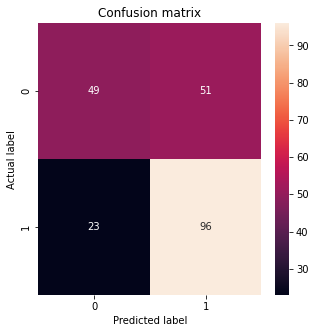

In [8]:
# Confusion matrix
y_pred_proba = model_voting.predict(X_test)
y_pred_binary = np.where(y_pred_proba > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred_binary)
print(classification_report(y_test, y_pred_binary))

# Plot
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

#### Note: Training and test data were only taken from 2017 to 2019 due to the market sentiment variables (NLP) produced only during this period.